## 기울기보정 (Deskew)
텍스트가 포함된 이미지에서 정확히 알 수 없는 각도로 회전된 이미지를 기울기 각도를 계산하여 기울어진 부분을 회전하기 위함

양식은 출력하는 방법(온라인, 무인발급기, 구청등)과 지역에 따라 다르고 지속적으로 변화하고 통제되지 않은 문서 촬영환경에서 제출되는 경우에는 품질을 
보장 할 수 없습니다.  
사용자가 이미지 보정이 가능한 경우에는 예상치 못한 형태의 이미지로 변환되기도 합니다.  
그리고 이미지 전송과정에서 화질이 저하되기도 하죠.  
무조건 제출하는 고객에게 좋은 품질에 동일한 양식으로 맞추라고 강요하기에는 무리가 있습니다. 

### Import Packages

In [3]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils

### 공통 Function
Jupyter Notebook 또는 Colab에서 이미지를 확인하기위한 Function

In [4]:
def plt_imshow(img=None, title='image', figsize=(8, 5)):
    '''
    :param img: (numpy) or (list - numpy)
    :param title: (str) or (list - str)
    :param figsize: (tuple)
    :return: None
    '''
    plt.figure(figsize=figsize)

    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []

            for i in range(len(img)):
                titles.append(title)

        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                try:
                    rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
                except:
                    rgbImg = img[i]
            else:
                try:
                    rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
                except:
                    rgbImg = img[i]

            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])

        plt.show()
    else:
        if len(img.shape) < 3:
            try:
                rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            except:
                rgbImg = img
        else:
            try:
                rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            except:
                rgbImg = img

        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()

입력된 각도에 맞게 이미지를 회전하는 Function  
중심점, 기울기를 이용하여 Affine Transformations(warpAffine) 합니다. 

In [33]:
def rotate(img, angle, resize=True, border_mode=cv2.BORDER_REPLICATE, border_value=None):
    '''
    :param img: (numpy) or (list - numpy)
    :param title: (str) or (list - str)
    :param figsize: (tuple)
    :return: None
    '''
    if border_mode == cv2.BORDER_REPLICATE:
        border_value = None
    
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D(center=(w // 2, h // 2), angle=angle, scale=1.0)
    output_image = cv2.warpAffine(src=img, M=M, dsize=(w, h), flags=cv2.INTER_NEAREST, borderMode=border_mode, borderValue=border_value,)

    if resize is True:
        output_image = cv2.resize(output_image, (w, h))
        
    return output_image

---

### 1. 텍스트 Bounding Box를 이용한 기울기 계산 (OLD)
1) 이미지에서 텍스트 블록을 감지합니다.
    > 이미지를 GrayScale로 변환하고 전경을 뒤집어 글짜는 흰색, 배경은 검정으로 변환  
    > 이미지 임계처리를 통해서 이진화 (배경은 0, 글씨는 255)  
    > ```cv2.minAreaRect```함수는 -90 ~ 0 범위의 각도값을 반환하기때문에 -45보다 작은 경우 90도을 더함  
    > **-45보다 큰 경우는 반대값을 반환하였으나, 테스트 중 지나치게 회전되는 경우가 존재하여 90도에 각도값을 빼도록 수정**
2) 회전된 텍스트의 각도를 계산합니다.
3) 기울어진 부분을 수정하기 위해 이미지를 회전합니다.

In [6]:
def get_angle_bbox_old(img, angle_max=360, angle_min=0):
    angle = 0
    
    if len(img.shape) < 3:
        gray = img
    else:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    gray = cv2.bitwise_not(gray)

    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]   
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]
    
    # print(angle)
    
    if angle < -45:
        angle = -(90 + angle)
    else:
        # angle = -angle
        angle = 90-angle
        
    if abs(angle) > angle_max or abs(angle) < angle_min:
        angle = 0

    return angle

#### 정상 CASE

Angle : 14.285621643066406 degrees


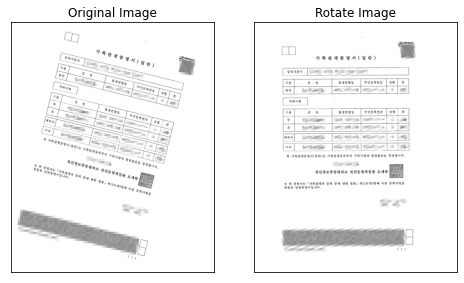

In [35]:
img_path = '../test_image/test_image1.jpg'
img = cv2.imread(img_path)
angle = get_angle_bbox_old(img)
print('Angle : {} degrees'.format(angle))

rotate_img = rotate(img, angle)

plt_imshow([img, rotate_img], ['Original Image', 'Rotate Image'])

#### 오류 CASE
회전이 필요없지만 회전이 되는 경우

Angle : 0.0 degrees


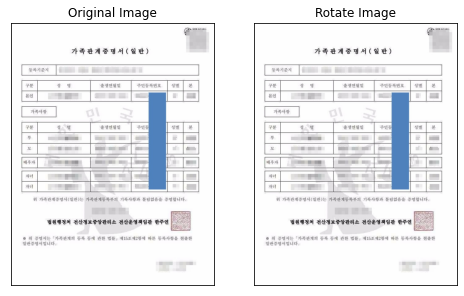

In [9]:
img_path = '../test_image/test_image2.jpg'
img = cv2.imread(img_path)
angle = get_angle_bbox_old(img)
print('Angle : {} degrees'.format(angle))

rotate_img = rotate(img, angle)

plt_imshow([img, rotate_img], ['Original Image', 'Rotate Image'])

---
### 2. 텍스트 Bounding Box를 이용한 기울기 계산 (NEW)
1) 이미지에서 텍스트 블록을 감지합니다.
    > 이미지를 GrayScale로 변환하고 전경을 뒤집어 글짜는 흰색, 배경은 검정으로 변환  
    > 이미지 임계처리를 통해서 이진화 (배경은 0, 글씨는 255)  
    > ```cv2.minAreaRect```함수는 -90 ~ 0 범위의 각도값을 반환하기때문에 -45보다 작은 경우 90도을 더함  
    > -45보다 큰 경우는 역수로 기울기를 산정  
    > **contours를 찾는 방식을 ```np.column_stack```에서 ```cv2.findContours```으로 변경**
2) 회전된 텍스트의 각도를 계산합니다.
3) 기울어진 부분을 수정하기 위해 이미지를 회전합니다.

In [10]:
def get_angle_bbox(img, angle_max=360, angle_min=0, debug=False):
    angle = 0
    
    # 이미지를 GrayScale로 변환하고 전경을 뒤집어 글짜는 흰색, 배경은 검정으로 변환합니다.
    if len(img.shape) < 3:
        gray = img
    else:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    gray = cv2.bitwise_not(gray)

    # 이미지 임계처리를 통해서 이진화 (배경은 0, 글씨는 255)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]   
    contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    points = []

    for h, cnt in enumerate(contours):
        area = cv2.contourArea(cnt)
        if area >= 90:
            for p in cnt:
                points.append(p[0])
    
    points = np.array(points)
    
    # `cv2.minAreaRect`함수는 [-90, 0] 범위의 각도값을 반환합니다.
    rect = cv2.minAreaRect(points)
    angle = rect[-1]
    
    # print(angle)
    if angle < -45:
        angle = -(90 + angle)
    elif angle > 45:
        angle = -angle
        
        if angle < -45:
            angle = -(90 + angle)
    
    if abs(angle) > angle_max or abs(angle) < angle_min:
        angle = 0
    
    if debug:        
        box = np.int0(cv2.boxPoints(rect))
        bounding_box_img = cv2.drawContours(img.copy(), [box], 0, (0, 255, 0), 3)
        plt_imshow(bounding_box_img, 'Bounding Box Image')

    return angle

#### 정상 CASE

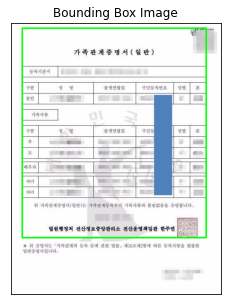

(857, 663, 3)
Angle : -0.0 degrees


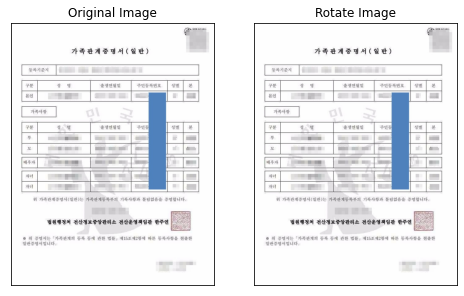

In [11]:
img_path = '../test_image/test_image2.jpg'
img = cv2.imread(img_path)
angle = get_angle_bbox(img, debug=True)
print(img.shape)
print('Angle : {} degrees'.format(angle))

rotate_img = rotate(img, angle)

plt_imshow([img, rotate_img], ['Original Image', 'Rotate Image'])

#### 오류 CASE
심각한 오류는 아니지만 기울기 산정이 부정확한 경우가 있음

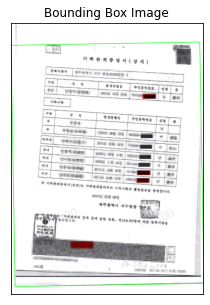

(2338, 1653, 3)
Angle : -0.9781265258789062 degrees


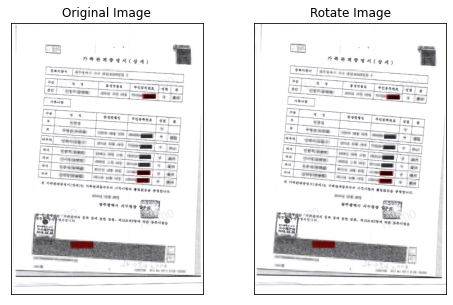

In [12]:
img_path = '../test_image/test_image3.jpg'
img = cv2.imread(img_path)
angle = get_angle_bbox(img, debug=True)
print(img.shape)
print('Angle : {} degrees'.format(angle))

rotate_img = rotate(img, angle)

plt_imshow([img, rotate_img], ['Original Image', 'Rotate Image'])

---
### 3. Image Alignment
이미지 정렬 알고리즘은 feature-based 방법 과 keypoint detectors (DoG, Harris, GFFT, etc.), local invariant descriptors (SIFT, SURF, ORB, etc.), and keypoint matching (RANSAC and its variants)을 이용합니다.

**양식이 생각보다 다양해서 Template 기반의 정렬은 어렵다고 판단**

In [13]:
def alignImages(img, template, maxFeatures=500, keepPercent=0.2):
    aligned = None
    
    # 입력 이미지와 템플릿을 모두 회색조로 변환
    imageGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    templateGray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

    # ORB를 사용하여 키포인트를 감지하고 로컬 추출 (이진)
    # invariant features
    # cv2.ORB_create(최대 피처 수, 스케일 계수, 피라미드 레벨, 엣지 임곗값, 시작 피라미드 레벨, 비교점, 점수 방식, 패치 크기, FAST 임곗값)
    orb = cv2.ORB_create(nfeatures=maxFeatures)
    (kpsA, descsA) = orb.detectAndCompute(imageGray, None)
    (kpsB, descsB) = orb.detectAndCompute(templateGray, None)

    # match the features
    method = cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
    matcher = cv2.DescriptorMatcher_create(method)
    matches = matcher.match(descsA, descsB, None)

    # sort the matches by their distance (the smaller the distance,
    # the "more similar" the features are)
    matches = sorted(matches, key=lambda x:x.distance)

    # keep only the top matches
    keep = int(len(matches) * keepPercent)
    matches = matches[:keep]
    
    src = img.copy()
    for i in matches[:keep]:
        idx = i.queryIdx
        x1, y1 = kpsA[idx].pt
        cv2.circle(src, (int(x1), int(y1)), 5, (255, 0, 255), 5)
        
        break

    # check to see if we should visualize the matched keypoints
    matchedVis = cv2.drawMatches(img, kpsA, template, kpsB, matches, None)
    matchedVis = imutils.resize(matchedVis, width=1000)

    # allocate memory for the keypoints (x,y-coordinates) from the
    # top matches -- we'll use these coordinates to compute our
    # homography matrix
    ptsA = np.zeros((len(matches), 2), dtype="float")
    ptsB = np.zeros((len(matches), 2), dtype="float")
    
    # loop over the top matches
    for (i, m) in enumerate(matches):
        # indicate that the two keypoints in the respective images
        # map to each other
        ptsA[i] = kpsA[m.queryIdx].pt
        ptsB[i] = kpsB[m.trainIdx].pt
        

    # compute the homography matrix between the two sets of matched
    # points
    (mtrx, mask) = cv2.findHomography(srcPoints=ptsA, dstPoints=ptsB, method=cv2.RANSAC)
    
    
    if convertible(mtrx, threshold=500):
        # use the homography matrix to align the images
        (h, w) = template.shape[:2]
        aligned = cv2.warpPerspective(img, mtrx, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

        plt_imshow([src, matchedVis], ["Features Image", "Matched Keypoints"])
    else:
        '''
        Alignment 불가 시 Deskewing -> Autocrop 수행
        '''
        print('Image Alignment (Skip)')
        # deskewing_image = imgDeskewing(fax_img, inAngle=0.5)
        # crop_image = imgAutocrop(deskewing_image, 0.8, 100, 100)
        # aligned = cv2.resize(crop_image, dsize=(template.shape[1], template.shape[0]))
    
    return aligned

def convertible(mtrx, threshold=500):
    '''
    homography matrix 값이 큰 경우 이미지 왜곡이 심해지기 때문에 특정 값 이상인 경우 변환하지 않기위함
    '''
    abs_mtrx = abs(mtrx.astype(int))
    # print(abs_mtrx.max())
    
    return abs_mtrx.max() < threshold

In [14]:
img_path = '../test_image/test_image1.jpg'
img = cv2.imread(img_path)
template_img_path = '../test_image/fr_template.jpg'
template_img = cv2.imread(template_img_path)

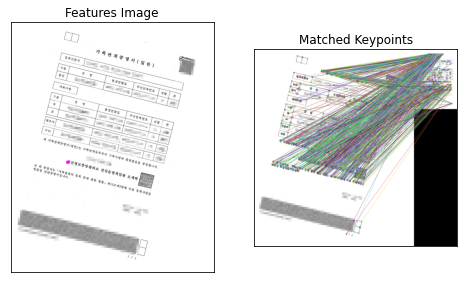

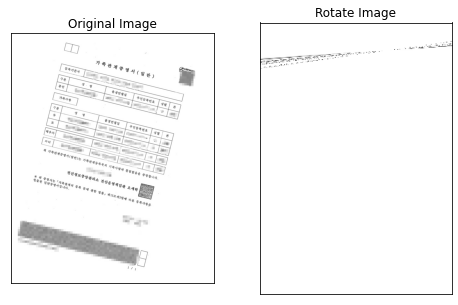

In [15]:
aligned = alignImages(img, template_img, maxFeatures=5000, keepPercent=0.2)
plt_imshow([img, aligned], ['Original Image', 'Rotate Image'])

---
### 4. Match Template 
```cv2.matchTemplate```함수를 이용하여 글자를 찾고 글자의 기울기를 구하려 했었는데, 생각해보니 기울어진 글씨는 템플릿과 다르기때문에 제외

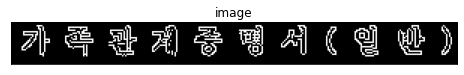

In [16]:
template = cv2.imread('../test_image/title.jpg')
template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
template = cv2.Canny(template, 50, 200)
(tH, tW) = template.shape[:2]
plt_imshow(template)

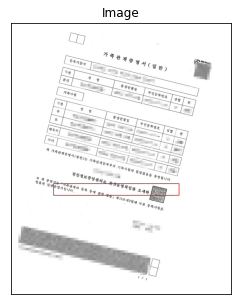

In [17]:
img_path = '../test_image/test_image1.jpg'
image = cv2.imread(img_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
found = None

for scale in np.linspace(0.2, 1.0, 20)[::-1]:
    # resize the image according to the scale, and keep track
    # of the ratio of the resizing
    resized = imutils.resize(gray, width = int(gray.shape[1] * scale))
    r = gray.shape[1] / float(resized.shape[1])

    # if the resized image is smaller than the template, then break
    # from the loop
    if resized.shape[0] < tH or resized.shape[1] < tW:
        break

    # detect edges in the resized, grayscale image and apply template
    # matching to find the template in the image
    edged = cv2.Canny(resized, 50, 200)
    result = cv2.matchTemplate(edged, template, cv2.TM_CCOEFF)
    (_, maxVal, _, maxLoc) = cv2.minMaxLoc(result)

    # if we have found a new maximum correlation value, then ipdate
    # the bookkeeping variable
    if found is None or maxVal > found[0]:
        found = (maxVal, maxLoc, r)

# unpack the bookkeeping varaible and compute the (x, y) coordinates
# of the bounding box based on the resized ratio
(_, maxLoc, r) = found
(startX, startY) = (int(maxLoc[0] * r), int(maxLoc[1] * r))
(endX, endY) = (int((maxLoc[0] + tW) * r), int((maxLoc[1] + tH) * r))

# draw a bounding box around the detected result and display the image
cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
plt_imshow(image, "Image")

---
### 5. Tesseract OSD(orientation and script detection)를 이용한 텍스트 방향 감지 
Tesseract는```pytesseract.image_to_osd```함수에서 입력 이미지 텍스트의 예상 회전각도를 반환합니다.  
반환된 각도로 이미지를 회전합니다.

Mac에서 실행 시 오류가 발생하여 일단 제외

In [19]:
import cv2
import pytesseract
from pytesseract import Output
from PIL import Image

In [25]:
# results = pytesseract.image_to_osd(Image.open('../test_image/title.jpg'), config='--psm 0 -c min_characters_to_try=5')

---
### 6. 이미지 저주파영역을 이용한 기울기 계산
```np.fft.fft2()```함수로 주파수 영역으로 변환을 이용한 기울기 계산  
이미지의 경우, 주파수 영역을 찾기 위해 2D Discrete Fourier Transfrom(DFT)를 사용합니다. DFT는 이론적인 푸리에 변환을 실제 컴퓨터에서 실행 가능하게 만든 알고리즘이며  
이 DFT를 훨씬 빠르게 처리하기 위한 것이 바로 고속 푸리에 변환(FFT, Fast Fourier Transform)입니다.  

스펙트럼은 푸리에 변환을 통해 얻은 각 주파수 성분이 원 신호(이미지)에 얼마나 강하게 포함되어 있는지 표현한 것입니다.

cv2.getOptimalDFTSize()를 이용하여 최적의 크기를 찾는다.

결과 중 가장 좋은 것 같으나 이미지 연산에 다소 시간이 소요됨 (3초), stat_end_point값을 낮추면 빨라지지만 기울기 보정 연산 성능은 떨어짐

In [26]:
def get_angle_fft(img, angle_max=360, angle_min=0, debug=False):
    """
    image : np.ndarray
    vertical_image_shape : int
    angle_max : float
    """ 
    stat_end_point = 10
    
    if len(img.shape) < 3:
        gray = img
    else:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    nw = nh = cv2.getOptimalDFTSize(max(gray.shape[:2]))
    opt_gray = cv2.copyMakeBorder(src=gray, top=0, bottom=nh - gray.shape[0], left=0, right=nw - gray.shape[1], borderType=cv2.BORDER_CONSTANT, value=255,)

    # thresh
    opt_gray = cv2.adaptiveThreshold(~opt_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, -10)

    # perform fft
    dft = np.fft.fft2(opt_gray)
    shifted_dft = np.fft.fftshift(dft)

    # get the magnitude (module)
    magnitude = np.abs(shifted_dft)
    
    r = c = magnitude.shape[0] // 2

    num = 20

    tr = np.linspace(-1 * stat_end_point, stat_end_point, int(stat_end_point * num * 2)) / 180 * np.pi
    profile_arr = tr.copy()

    def f(t):
        _f = np.vectorize(lambda x: magnitude[c + int(x * np.cos(t)), c + int(-1 * x * np.sin(t))])
        _l = _f(range(0, r))
        val_init = np.sum(_l)
        return val_init

    vf = np.vectorize(f)
    li = vf(profile_arr)

    angle = tr[np.argmax(li)] / np.pi * 180

    if abs(angle) > angle_max or abs(angle) < angle_min:
        angle = 0
        
    if debug:
        magnitude_spectrum = 20*np.log(np.abs(shifted_dft))
        plt_imshow([img, opt_gray, magnitude_spectrum], ['Original Image', 'OPT Image', 'Spectrum Image'])
        
    return angle

#### 정상 CASE

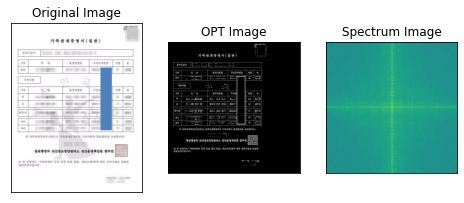

Angle : -0.12531328320802082 degrees


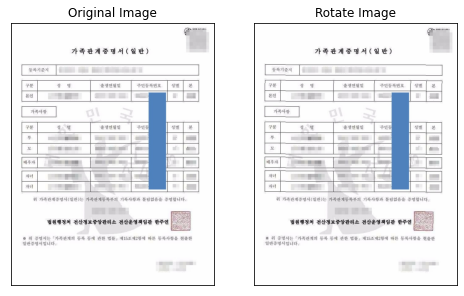

In [34]:
img_path = '../test_image/test_image2.jpg'
img = cv2.imread(img_path)
angle = get_angle_fft(img, debug=True)

print('Angle : {} degrees'.format(angle))

rotate_img = rotate(img, angle)

plt_imshow([img, rotate_img], ['Original Image', 'Rotate Image'])

---
### 7. Hough Transform을 이용한 기울기 측정
Hough Transform 기반의 비대칭도(Skewness) 감지  
직선 좌표에서 극좌표로 변환

* 이미지를 회색조로 변환
* Apple Canny 또는 Sobel 필터
* 0.1에서 180도 각도 사이의 허프 라인을 찾음
* line peak에서 각도 반올림 (소수점 이하 2자리까지)
* 가장 많이 발생하는 각도를 추출
* 해당 각도로 이미지 회전

결과도 좋고 속도도 빠름

Text(0.5, 1.0, 'Detected lines')

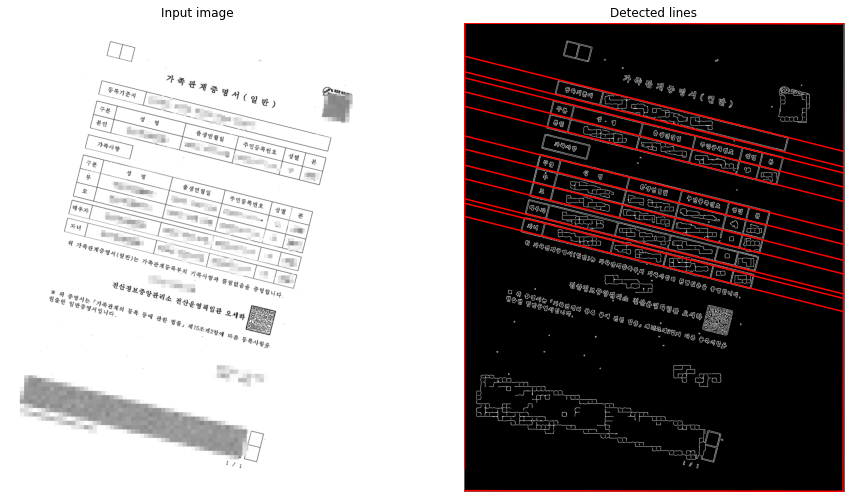

In [28]:
import numpy as np
from skimage.transform import hough_line, hough_line_peaks
from skimage.transform import rotate
from skimage.feature import canny
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from scipy.stats import mode

image = rgb2gray(img)

edges = canny(image)
# Classic straight-line Hough transform
tested_angles = np.deg2rad(np.arange(0.1, 180.0))
h, theta, d = hough_line(edges, theta=tested_angles)

# Generating figure 1
fig, axes = plt.subplots(1, 2, figsize=(15, 16))
ax = axes.ravel()

ax[0].imshow(image, cmap="gray")
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(edges, cmap="gray")
origin = np.array((0, image.shape[1]))

for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    ax[1].plot(origin, (y0, y1), '-r')
    
ax[1].set_xlim(origin)
ax[1].set_ylim((edges.shape[0], 0))
ax[1].set_axis_off()
ax[1].set_title('Detected lines')

In [29]:
def skew_angle_hough_transform(img):
    imagergb = rgba2rgb(img) if len(img.shape) == 3 and img.shape[2] == 4 else img
    img = rgb2gray(imagergb) if len(imagergb.shape) == 3 else imagergb
    # edges이미지로 변환
    edges = canny(img)
    # 0.1 - 180도 사이의 직선 Hough 변환
    tested_angles = np.deg2rad(np.arange(0.1, 180.0))
    h, theta, d = hough_line(edges, theta=tested_angles)
    
    # Line Peak와 각도 찾기
    accum, angles, dists = hough_line_peaks(h, theta, d)
    
    # 각도를 소수점 이하 2자리까지 반올림하고 가장 일반적인 각도를 찾음
    most_common_angle = mode(np.around(angles, decimals=2))[0]
    
    # 회전 각도를 각도로 변환
    skew_angle = np.rad2deg(most_common_angle - np.pi/2)
    return skew_angle[0]

Angle : 14.278318713809831 degrees


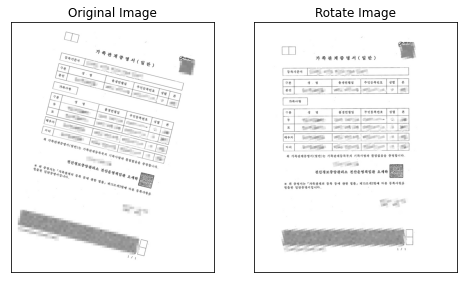

In [39]:
img_path = '../test_image/test_image1.jpg'
img = cv2.imread(img_path)
angle = skew_angle_hough_transform(img)

print('Angle : {} degrees'.format(angle))

rotate_img = rotate(img, angle)

plt_imshow([img, rotate_img], ['Original Image', 'Rotate Image'])